## Script que faz a redução de dimensionalidade e clustering

Este script utiliza diferentes métodos para **redução de dimensionalidade**, permitindo analisar e visualizar dados de alta dimensão de forma mais compreensível. Os métodos aplicados incluem:

- **PCA (Principal Component Analysis)**:  
  Método linear que reduz a dimensionalidade preservando a maior parte da variância nos dados. É rápido, simples e eficaz para dados com estrutura linear.

- **t-SNE (t-Distributed Stochastic Neighbor Embedding)**:  
  Técnica não linear de redução de dimensionalidade, amplamente utilizada para visualização. Prioriza a **preservação de relações locais**, tornando-a ideal para explorar agrupamentos ou padrões em dados complexos.

- **KPCA (Kernel Principal Component Analysis)**:  
  Extensão não linear do PCA, que utiliza funções kernel para capturar relações complexas nos dados. Útil em cenários onde o PCA tradicional não é suficiente.

- **UMAP (Uniform Manifold Approximation and Projection)**:  
  Técnica moderna e eficiente que reduz a dimensionalidade **preservando tanto estruturas locais quanto globais**. É rápida, escalável e frequentemente usada para visualização e análise de dados complexos.


## Bibliotecas

In [1]:
# Bibliotecas para manipulação de dados e cálculo
import pandas as pd
import numpy as np
import time  # Para medir o tempo de execução

# Bibliotecas para visualização
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Bibliotecas de aprendizado de máquina
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Bibliotecas para clusterização
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import hdbscan

# Métricas para avaliação de clusters
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Hierarquia para dendrogramas
from scipy.cluster.hierarchy import dendrogram, linkage

# Biblioteca para redução de dimensionalidade moderna
import umap


In [2]:
douItem = 2
secao = f'Secao0{douItem}'
# varEmbedding = "USE"
varEmbedding = "SBERT"

# Lê o arquivo Parquet
df_portarias_mgi = pd.read_parquet(f'./saida/04_2_DOU{secao}_portarias_mgi_tratado_NER_lematizado_embeddings{varEmbedding}.parquet', engine='pyarrow')  # ou engine='fastparquet'

# Exibe as primeiras linhas do DataFrame
df_portarias_mgi.shape


(19258, 40)

In [3]:
df_portarias_mgi.head()

,id,name,idOficio,pubName,artType,pubDate,artClass,artCategory,artSize,artNotes,...,Total_palavras,TextoTratado,TextoTratado_TotalPalavras,Texto_sem_nomes,Nomes,TextoTratadoSemNomes,TextoTratadoSemNomes_TotalPalavras,TextoTratadoSemNomesLemmatized,TextoTratadoSemNomesLemmatized_TotalPalavras,SBERT_Embeddings
0,30266027,PORTARIA DE PESSOAL 529,9368436,DO2,Portaria,2023-01-25,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,358,"sgp/sedgg/me nº 529, 17 janeiro 2023 secretari...",231,None,"sergio eduardo arbulu, anderson pereira silvy,...","sgp / sedgg / me nº 529 , 17 janeiro 2023 secr...",268,sgp Sedgg nº 529 17 janeiro 2023 secretario ge...,182,"[0.027546512, -0.014280515, 0.011502093, -0.02..."
1,30264410,ATO PORTARIA 655,9368530,DO2,Portaria,2023-01-25,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,245,"portaria sgp/sedgg/me nº 655, 23 janeiro 2023 ...",158,None,"eliane araujo franklin, eduardo arbulu","portaria sgp / sedgg / me nº 655 , 23 janeiro ...",189,portar sgp Sedgg nº 655 23 janeiro 2023 secret...,127,"[-0.04772521, -0.012842229, -0.03631893, -0.06..."
2,30265009,ATO PORTARIA DE PESSOAL 461,9368536,DO2,Portaria,2023-01-25,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,251,"sgp/sedgg/me nº 461, 16 janeiro 2023 secretari...",160,None,eduardo arbulu,"sgp / sedgg / me nº 461 , 16 janeiro 2023 secr...",197,sgp Sedgg nº 461 16 janeiro 2023 secretario ge...,132,"[-0.046167854, -0.007756816, -0.051473927, -0...."
3,30265678,ATO PORTARIA DE PESSOAL SGP 606,9368541,DO2,Portaria,2023-01-25,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,251,"sgp/sedgg/me nº 606, 19 janeiro 2023 secretari...",158,None,eduardo arbulu,"sgp / sedgg / me nº 606 , 19 janeiro 2023 secr...",187,sgp Sedgg nº 606 19 janeiro 2023 secretario ge...,134,"[0.0063266293, -0.032969587, -0.08793325, -0.0..."
4,30266030,ATO PORTARIA DE PESSOAL SGP 517,9368573,DO2,Portaria,2023-01-25,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,243,"sgp/sedgg/me nº 517, 17 janeiro 2023 secretari...",158,None,"roberto jorge ferreira, termino exercicio, edu...","sgp / sedgg / me nº 517 , 17 janeiro 2023 secr...",177,sgp Sedgg nº 517 17 janeiro 2023 secretario ge...,122,"[-0.03212297, -0.00869727, -0.057080653, -0.03..."


## PCA

Tempo para extrair os embeddings: 0.03 segundos
Tempo para redução dimensional (PCA): 0.10 segundos


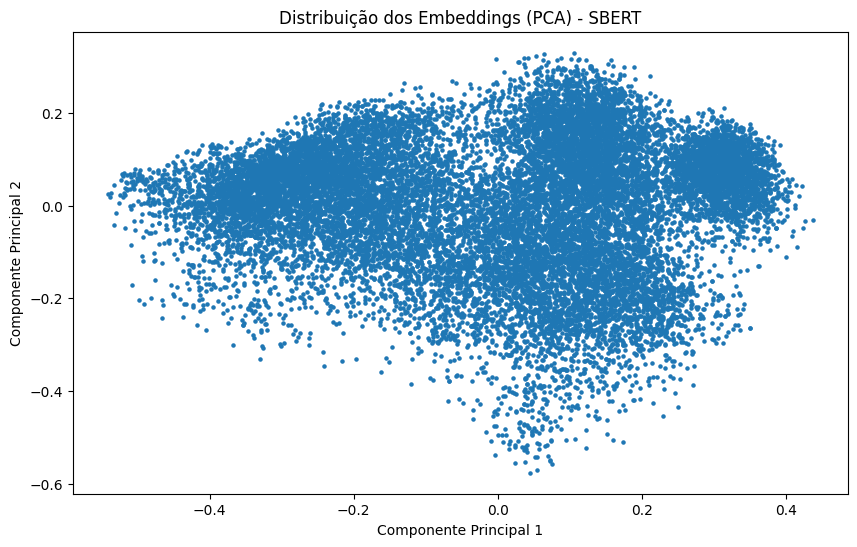

In [4]:
# Medir o tempo de extração dos embeddings
start_time = time.time()

# Extrair os embeddings da coluna 'USE_Embeddings' para um array NumPy
embeddings = np.vstack(df_portarias_mgi[f'{varEmbedding}_Embeddings'])
extraction_time = time.time() - start_time
print(f"Tempo para extrair os embeddings: {extraction_time:.2f} segundos")

# Medir o tempo de redução com PCA
start_time = time.time()

# Reduzir para 2 dimensões com PCA
pca = PCA(n_components=2)
embeddings_PCA_2d = pca.fit_transform(embeddings)
reduction_time = time.time() - start_time
print(f"Tempo para redução dimensional (PCA): {reduction_time:.2f} segundos")

# Plotar os embeddings reduzidos
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_PCA_2d[:, 0], embeddings_PCA_2d[:, 1], s=5)
plt.title(f"Distribuição dos Embeddings (PCA) - {varEmbedding}")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()


## t-SNE

Tempo para extrair os embeddings: 0.04 segundos
Tempo para redução dimensional (t-SNE): 146.49 segundos


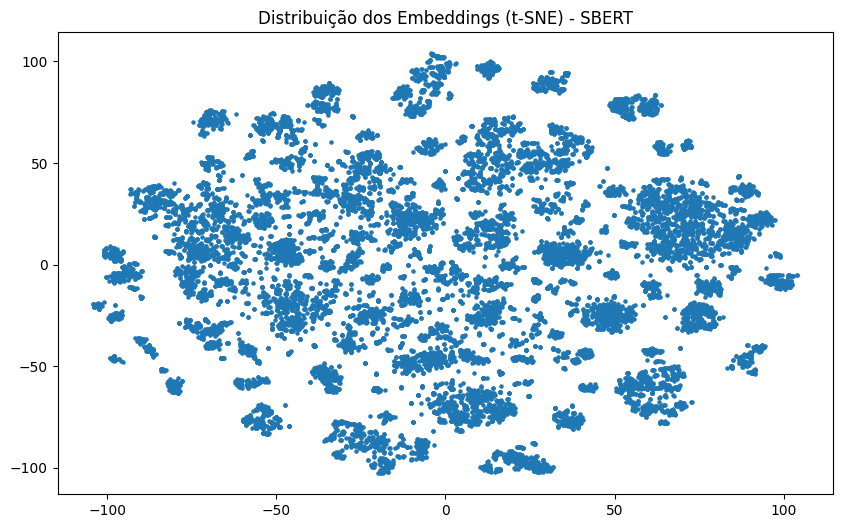

In [5]:
# Medir o tempo de extração dos embeddings
start_time = time.time()

# Extrair os embeddings da coluna 'USE_Embeddings' para um array NumPy
embeddings = np.vstack(df_portarias_mgi[f'{varEmbedding}_Embeddings'])
extraction_time = time.time() - start_time
print(f"Tempo para extrair os embeddings: {extraction_time:.2f} segundos")

# Medir o tempo de redução com t-SNE
start_time = time.time()
# Reduzir para 2 dimensões com t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_TSNE_2d = tsne.fit_transform(embeddings)
reduction_time = time.time() - start_time
print(f"Tempo para redução dimensional (t-SNE): {reduction_time:.2f} segundos")

# Plotar os embeddings reduzidos
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_TSNE_2d[:, 0], embeddings_TSNE_2d[:, 1], s=5)
plt.title(f'Distribuição dos Embeddings (t-SNE) - {varEmbedding}')
plt.show()


## Kpca

Tempo para extrair os embeddings: 0.04 segundos
Tempo para redução dimensional (KPCA): 16.85 segundos


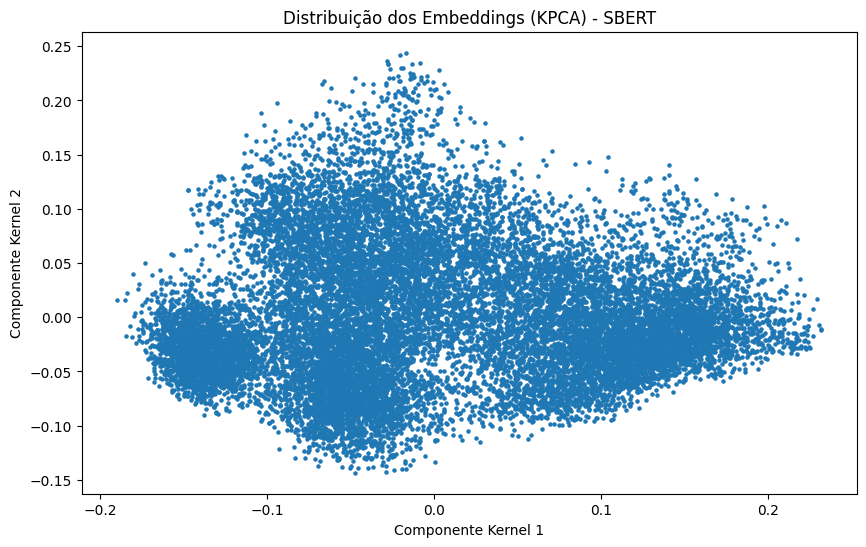

In [6]:
# Medir o tempo de extração dos embeddings
start_time = time.time()

# Extrair os embeddings da coluna 'USE_Embeddings' para um array NumPy
embeddings = np.vstack(df_portarias_mgi[f'{varEmbedding}_Embeddings'])
extraction_time = time.time() - start_time
print(f"Tempo para extrair os embeddings: {extraction_time:.2f} segundos")

# Medir o tempo de redução com KPCA
start_time = time.time()

# Reduzir para 2 dimensões com Kernel PCA
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.1)  # Usando kernel RBF
embeddings_kpca_2d = kpca.fit_transform(embeddings)
reduction_time = time.time() - start_time
print(f"Tempo para redução dimensional (KPCA): {reduction_time:.2f} segundos")

# Plotar os embeddings reduzidos
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_kpca_2d[:, 0], embeddings_kpca_2d[:, 1], s=5)
plt.title(f'Distribuição dos Embeddings (KPCA) - {varEmbedding}')
plt.xlabel("Componente Kernel 1")
plt.ylabel("Componente Kernel 2")
plt.show()


## PCA e t-SNE

Tempo para extrair os embeddings: 0.04 segundos
Tempo para redução dimensional (PCA): 0.09 segundos
Tempo para redução dimensional (t-SNE): 158.93 segundos


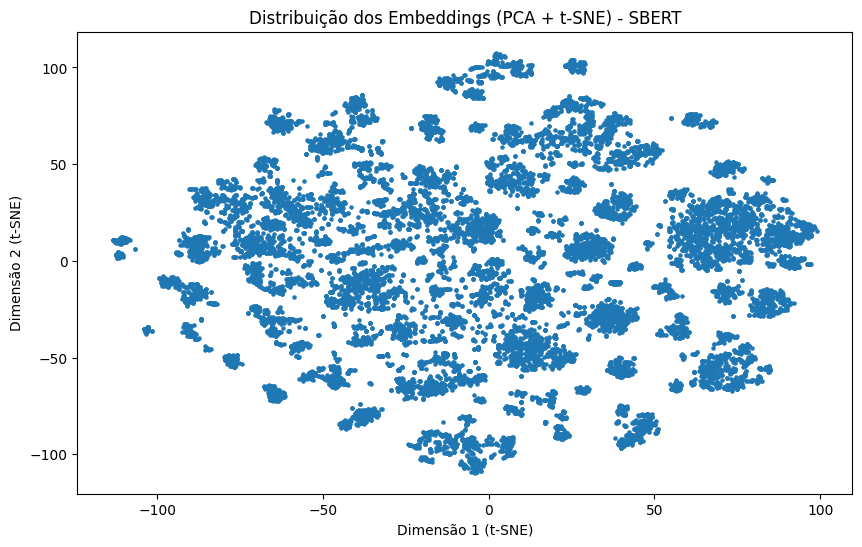

In [7]:
# Medir o tempo de extração dos embeddings
start_time = time.time()

# Extrair os embeddings da coluna 'USE_Embeddings' para um array NumPy
embeddings = np.vstack(df_portarias_mgi[f'{varEmbedding}_Embeddings'])
extraction_time = time.time() - start_time
print(f"Tempo para extrair os embeddings: {extraction_time:.2f} segundos")

# Etapa 1: Reduzir dimensionalidade com PCA
start_time = time.time()
pca = PCA(n_components=50)  # Reduzir para 50 dimensões intermediárias
embeddings_pca = pca.fit_transform(embeddings)
pca_time = time.time() - start_time
print(f"Tempo para redução dimensional (PCA): {pca_time:.2f} segundos")

# Etapa 2: Reduzir ainda mais com t-SNE
start_time = time.time()
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_pca_tsne = tsne.fit_transform(embeddings_pca)
tsne_time = time.time() - start_time
print(f"Tempo para redução dimensional (t-SNE): {tsne_time:.2f} segundos")

# Plotar os embeddings reduzidos
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_pca_tsne[:, 0], embeddings_pca_tsne[:, 1], s=5)
plt.title(f'Distribuição dos Embeddings (PCA + t-SNE) - {varEmbedding}')
plt.xlabel("Dimensão 1 (t-SNE)")
plt.ylabel("Dimensão 2 (t-SNE)")
plt.show()


## UMAP

Tempo para extrair os embeddings: 0.04 segundos


C:\Users\aqcor\anaconda3\envs\PPCA_MD\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Tempo para redução dimensional (UMAP): 67.43 segundos


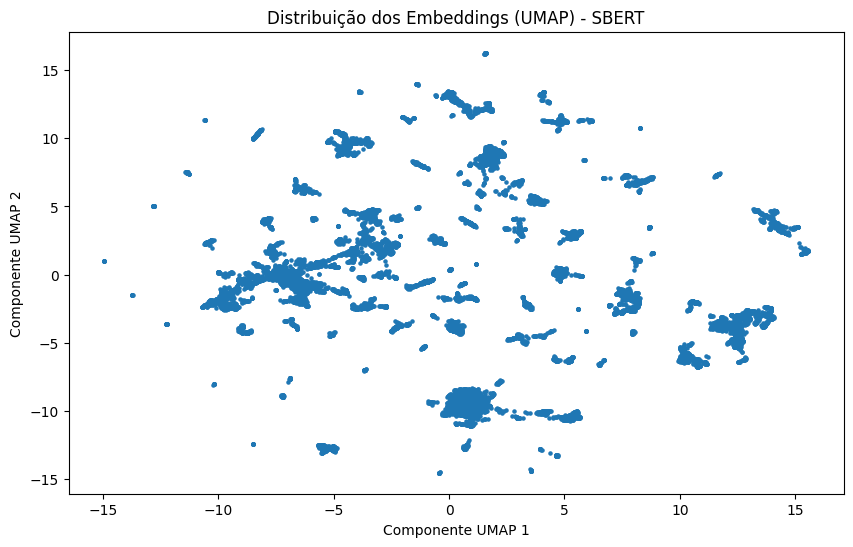

In [8]:
# Medir o tempo de extração dos embeddings
start_time = time.time()

# Extrair os embeddings da coluna 'USE_Embeddings' para um array NumPy
embeddings = np.vstack(df_portarias_mgi[f'{varEmbedding}_Embeddings'])
extraction_time = time.time() - start_time
print(f"Tempo para extrair os embeddings: {extraction_time:.2f} segundos")

# Medir o tempo de redução com UMAP
start_time = time.time()

# Reduzir para 2 dimensões com UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
embeddings_umap_2d = umap_model.fit_transform(embeddings)
reduction_time = time.time() - start_time
print(f"Tempo para redução dimensional (UMAP): {reduction_time:.2f} segundos")

# Plotar os embeddings reduzidos
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_umap_2d[:, 0], embeddings_umap_2d[:, 1], s=5)
plt.title(f'Distribuição dos Embeddings (UMAP) - {varEmbedding}')
plt.xlabel("Componente UMAP 1")
plt.ylabel("Componente UMAP 2")
plt.show()


## t-SNE + K-Means

Tempo de execução do K-Means: 0.03 segundos 
Clusters = 4
Silhouette Score: 0.38
Davies-Bouldin Score: 0.81
Calinski-Harabasz Score: 16742.54


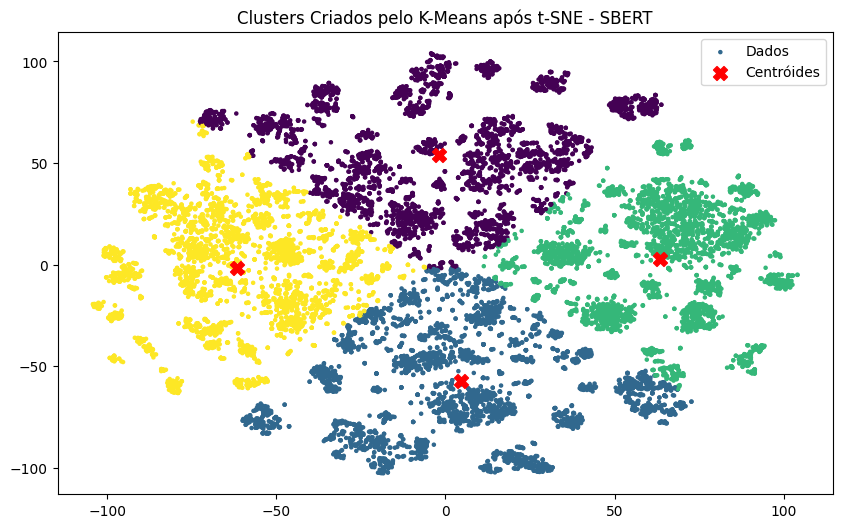

In [9]:
# Medir o tempo de execução do K-Means
start_time = time.time()

# Aplicar K-Means nos dados reduzidos
n_clusters = 4  # Definir o número de clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(embeddings_TSNE_2d)

execution_time = time.time() - start_time
print(f"Tempo de execução do K-Means: {execution_time:.2f} segundos ")
print(f'Clusters = {n_clusters}')

# Validar a clusterização com métricas não supervisionadas
silhouette_avg = silhouette_score(embeddings_TSNE_2d, kmeans.labels_)
davies_bouldin = davies_bouldin_score(embeddings_TSNE_2d, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(embeddings_TSNE_2d, kmeans.labels_)

print(f"Silhouette Score: {silhouette_avg:.2f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.2f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.2f}")

# Obter os clusters
df_portarias_mgi['Cluster'] = kmeans.labels_

# Visualizar os clusters
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_TSNE_2d[:, 0], embeddings_TSNE_2d[:, 1], c=kmeans.labels_, cmap='viridis', s=5, label='Dados')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=100, marker='X', label='Centróides')
plt.title(f'Clusters Criados pelo K-Means após t-SNE - {varEmbedding}')
plt.legend()
plt.show()


## PCA + t-SNE + K-means

Tempo de execução do K-Means: 0.02 segundos
Clusters = 6
Silhouette Score: 0.37
Davies-Bouldin Score: 0.84
Calinski-Harabasz Score: 16311.41


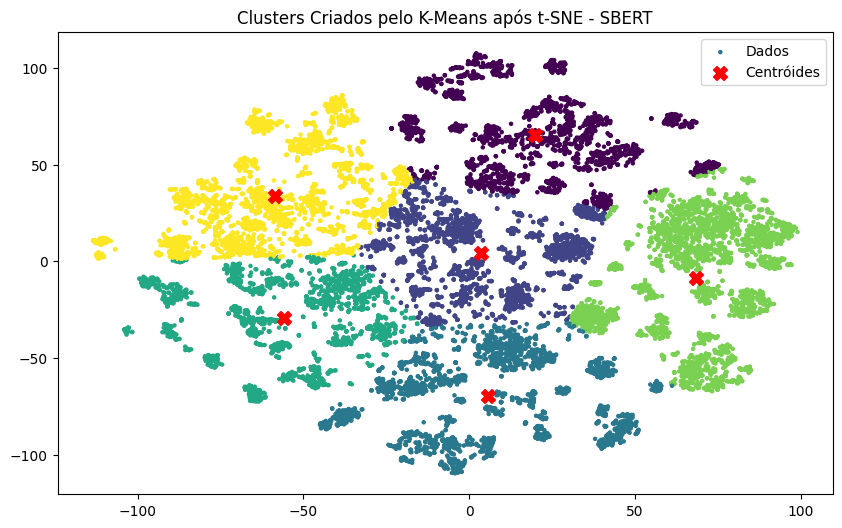

In [10]:
# Medir o tempo de execução do K-Means
start_time = time.time()

# Aplicar K-Means nos dados reduzidos
n_clusters = 6  # Definir o número de clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(embeddings_pca_tsne)

execution_time = time.time() - start_time
print(f"Tempo de execução do K-Means: {execution_time:.2f} segundos")
print(f'Clusters = {n_clusters}')

# Validar a clusterização com métricas não supervisionadas
silhouette_avg = silhouette_score(embeddings_pca_tsne, kmeans.labels_)
davies_bouldin = davies_bouldin_score(embeddings_pca_tsne, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(embeddings_pca_tsne, kmeans.labels_)

print(f"Silhouette Score: {silhouette_avg:.2f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.2f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.2f}")

# Obter os clusters
df_portarias_mgi['Cluster'] = kmeans.labels_

# Visualizar os clusters
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_pca_tsne[:, 0], embeddings_pca_tsne[:, 1], c=kmeans.labels_, cmap='viridis', s=5, label='Dados')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=100, marker='X', label='Centróides')
plt.title(f'Clusters Criados pelo K-Means após t-SNE - {varEmbedding}')
plt.legend()
plt.show()


## UMAP + K-means

Tempo de execução do K-Means: 0.03 segundos
Clusters = 6
Silhouette Score: 0.43
Davies-Bouldin Score: 0.83
Calinski-Harabasz Score: 20232.21


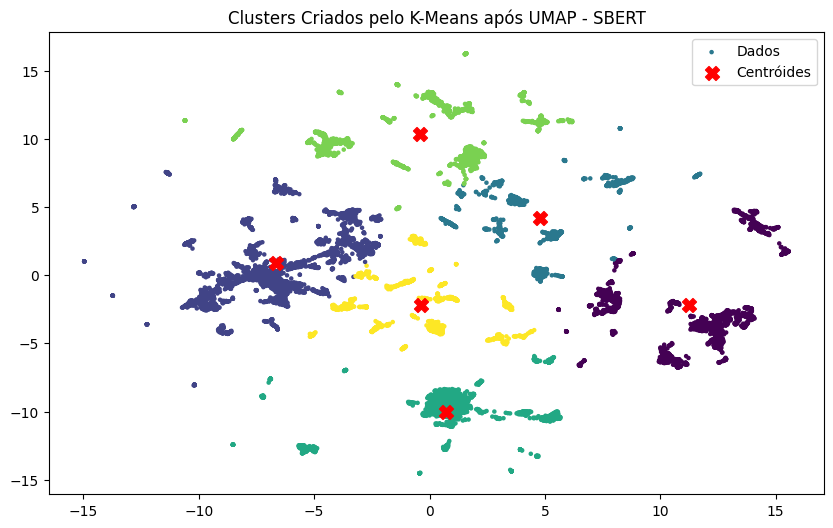

In [11]:
# Medir o tempo de execução do K-Means
start_time = time.time()

# Aplicar K-Means nos dados reduzidos
n_clusters = 6  # Definir o número de clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(embeddings_umap_2d)

execution_time = time.time() - start_time
print(f"Tempo de execução do K-Means: {execution_time:.2f} segundos")
print(f'Clusters = {n_clusters}')

# Validar a clusterização com métricas não supervisionadas
silhouette_avg = silhouette_score(embeddings_umap_2d, kmeans.labels_)
davies_bouldin = davies_bouldin_score(embeddings_umap_2d, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(embeddings_umap_2d, kmeans.labels_)

print(f"Silhouette Score: {silhouette_avg:.2f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.2f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.2f}")

# Obter os clusters
df_portarias_mgi['Cluster'] = kmeans.labels_

# Visualizar os clusters
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_umap_2d[:, 0], embeddings_umap_2d[:, 1], c=kmeans.labels_, cmap='viridis', s=5, label='Dados')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=100, marker='X', label='Centróides')
plt.title(f'Clusters Criados pelo K-Means após UMAP - {varEmbedding}')
plt.legend()
plt.show()


## Hierarchical Clustering

In [12]:
# Definindo o número de clusters
n_clusters = 6

# Aplicação do Hierarchical Clustering (Agglomerative)
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels = hierarchical.fit_predict(embeddings_pca_tsne)

# Calcular métricas de clusterização
if len(set(labels)) > 1:  # Garantir que há mais de um cluster
    silhouette_avg = silhouette_score(embeddings_pca_tsne, labels)
    davies_bouldin = davies_bouldin_score(embeddings_pca_tsne, labels)
    calinski_harabasz = calinski_harabasz_score(embeddings_pca_tsne, labels)

    print(f"Índice de Silhueta: {silhouette_avg:.4f}")
    print(f"Índice de Davies-Bouldin: {davies_bouldin:.4f}")
    print(f"Índice de Calinski-Harabasz: {calinski_harabasz:.4f}")
else:
    print("Não há clusters suficientes para calcular as métricas.")

Índice de Silhueta: 0.3168
Índice de Davies-Bouldin: 0.8914
Índice de Calinski-Harabasz: 13853.4053


## t-NSE + DBSCAN

Índice de Silhueta (clusters válidos): 0.5236
Índice de Davies-Bouldin (clusters válidos): 0.4682
Índice de Calinski-Harabasz (clusters válidos): 57871.2422
Proporção de ruído: 10.36%
Total de clusters válidos (excluindo ruído): 1683


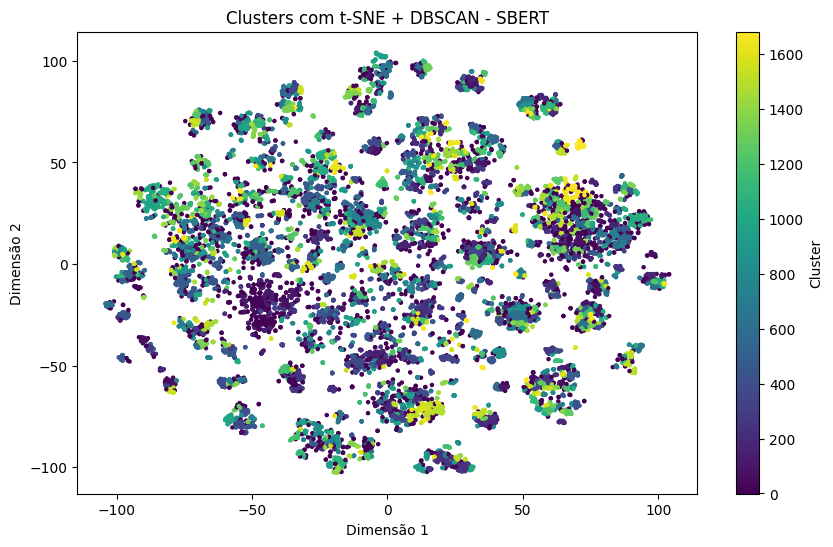

In [13]:
# Aplicação do DBSCAN nos dados reduzidos
dbscan = DBSCAN(eps=0.7, min_samples=3, metric='euclidean')
clusters = dbscan.fit_predict(embeddings_TSNE_2d)

# Adicionar clusters ao dataframe
df_portarias_mgi[f'Cluster_tnse_dbscan_{varEmbedding}'] = clusters

# Filtrar os dados para clusters válidos (excluindo ruído)
mask_valid_clusters = clusters != -1  # Ignorar rótulos de ruído (-1)
valid_embeddings = embeddings_TSNE_2d[mask_valid_clusters]
valid_clusters = clusters[mask_valid_clusters]

# Verificar se há clusters válidos suficientes
if len(set(valid_clusters)) > 1:  # Garantir que há mais de um cluster válido
    # Índice de Silhueta
    silhouette_avg = silhouette_score(valid_embeddings, valid_clusters)
    print(f"Índice de Silhueta (clusters válidos): {silhouette_avg:.4f}")

    # Índice de Davies-Bouldin
    davies_bouldin = davies_bouldin_score(valid_embeddings, valid_clusters)
    print(f"Índice de Davies-Bouldin (clusters válidos): {davies_bouldin:.4f}")

    # Índice de Calinski-Harabasz
    calinski_harabasz = calinski_harabasz_score(valid_embeddings, valid_clusters)
    print(f"Índice de Calinski-Harabasz (clusters válidos): {calinski_harabasz:.4f}")
else:
    print("Não há clusters suficientes para calcular as métricas.")

num_points = len(clusters)
num_noise = np.sum(clusters == -1)
noise_ratio = num_noise / num_points
print(f"Proporção de ruído: {noise_ratio:.2%}")

# Total de clusters válidos (excluindo ruído)
total_clusters_excl_noise = len(set(clusters) - {-1})  # Remove o cluster de ruído (-1)
print(f"Total de clusters válidos (excluindo ruído): {total_clusters_excl_noise}")

# Visualização dos clusters
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_TSNE_2d[:, 0], embeddings_TSNE_2d[:, 1], c=clusters, cmap='viridis', s=5)
plt.title(f"Clusters com t-SNE + DBSCAN - {varEmbedding}")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.colorbar(label="Cluster")
plt.show()


## UMAP + DBSCAN

Índice de Silhueta (clusters válidos): 0.3523
Índice de Davies-Bouldin (clusters válidos): 0.4228
Índice de Calinski-Harabasz (clusters válidos): 6507.6953
Proporção de ruído: 0.00%
Total de clusters válidos (excluindo ruído): 69


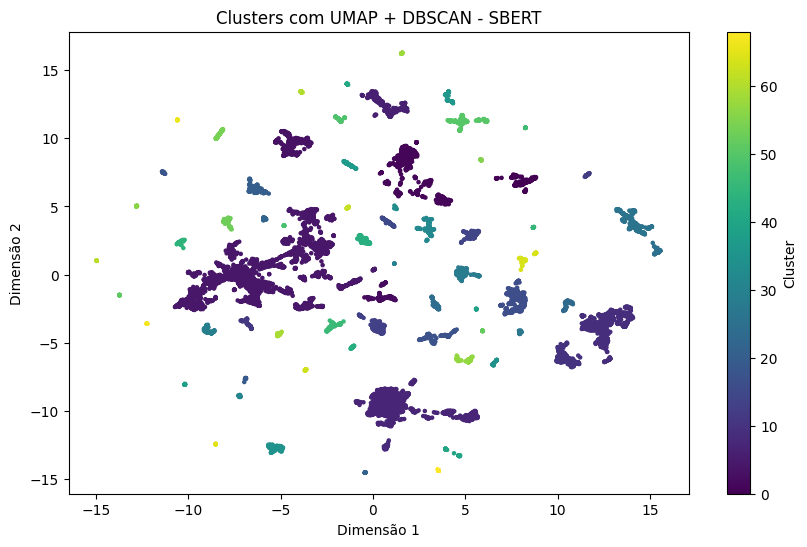

In [14]:
# Aplicação do DBSCAN nos dados reduzidos
dbscan = DBSCAN(eps=0.7, min_samples=3, metric='euclidean')
clusters = dbscan.fit_predict(embeddings_umap_2d)

# Adicionar clusters ao dataframe
df_portarias_mgi[f'Cluster_umap_dbscan_{varEmbedding}'] = clusters

# Filtrar os dados para clusters válidos (excluindo ruído)
mask_valid_clusters = clusters != -1  # Ignorar rótulos de ruído (-1)
valid_embeddings = embeddings_umap_2d[mask_valid_clusters]
valid_clusters = clusters[mask_valid_clusters]

# Verificar se há clusters válidos suficientes
if len(set(valid_clusters)) > 1:  # Garantir que há mais de um cluster válido
    # Índice de Silhueta
    silhouette_avg = silhouette_score(valid_embeddings, valid_clusters)
    print(f"Índice de Silhueta (clusters válidos): {silhouette_avg:.4f}")

    # Índice de Davies-Bouldin
    davies_bouldin = davies_bouldin_score(valid_embeddings, valid_clusters)
    print(f"Índice de Davies-Bouldin (clusters válidos): {davies_bouldin:.4f}")

    # Índice de Calinski-Harabasz
    calinski_harabasz = calinski_harabasz_score(valid_embeddings, valid_clusters)
    print(f"Índice de Calinski-Harabasz (clusters válidos): {calinski_harabasz:.4f}")
else:
    print("Não há clusters suficientes para calcular as métricas.")

num_points = len(clusters)
num_noise = np.sum(clusters == -1)
noise_ratio = num_noise / num_points
print(f"Proporção de ruído: {noise_ratio:.2%}")

# Total de clusters válidos (excluindo ruído)
total_clusters_excl_noise = len(set(clusters) - {-1})  # Remove o cluster de ruído (-1)
print(f"Total de clusters válidos (excluindo ruído): {total_clusters_excl_noise}")

# Visualização dos clusters
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_umap_2d[:, 0], embeddings_umap_2d[:, 1], c=clusters, cmap='viridis', s=5)
plt.title(f"Clusters com UMAP + DBSCAN - {varEmbedding}")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.colorbar(label="Cluster")
plt.show()


## t-NSE + HDBSCAN

Índice de Silhueta (clusters válidos): 0.4515
Índice de Davies-Bouldin (clusters válidos): 0.5607
Índice de Calinski-Harabasz (clusters válidos): 12431.7910
Proporção de ruído: 9.13%
Total de clusters válidos (excluindo ruído): 195


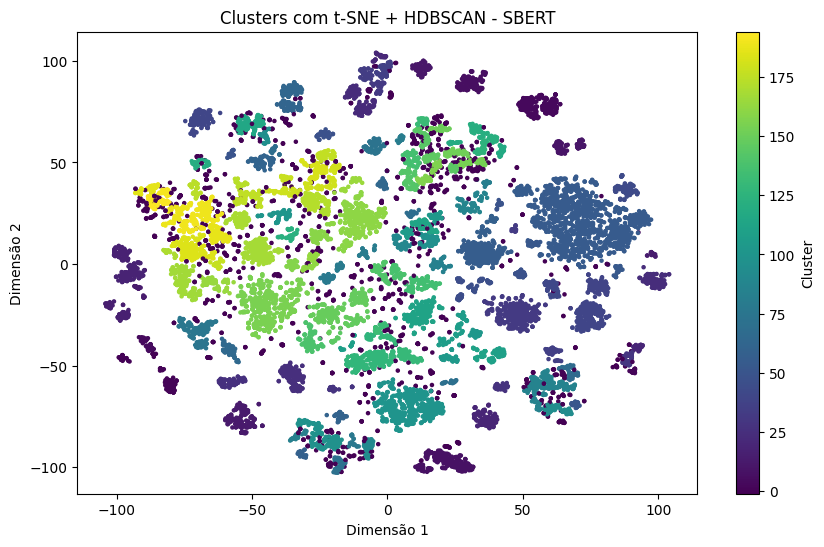

In [15]:
# Configurar HDBSCAN
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=6, metric='euclidean')
clusters = hdbscan_clusterer.fit_predict(embeddings_TSNE_2d)

# Adicionar clusters ao DataFrame
df_portarias_mgi[f'Cluster_tnse_hdbscan_{varEmbedding}'] = clusters

# Filtrar os dados para clusters válidos (excluindo ruído)
mask_valid_clusters = clusters != -1  # Ignorar rótulos de ruído (-1)
valid_embeddings = embeddings_TSNE_2d[mask_valid_clusters]
valid_clusters = clusters[mask_valid_clusters]

# Verificar se há clusters válidos suficientes
if len(set(valid_clusters)) > 1:  # Garantir que há mais de um cluster válido
    # Índice de Silhueta
    silhouette_avg = silhouette_score(valid_embeddings, valid_clusters)
    print(f"Índice de Silhueta (clusters válidos): {silhouette_avg:.4f}")

    # Índice de Davies-Bouldin
    davies_bouldin = davies_bouldin_score(valid_embeddings, valid_clusters)
    print(f"Índice de Davies-Bouldin (clusters válidos): {davies_bouldin:.4f}")

    # Índice de Calinski-Harabasz
    calinski_harabasz = calinski_harabasz_score(valid_embeddings, valid_clusters)
    print(f"Índice de Calinski-Harabasz (clusters válidos): {calinski_harabasz:.4f}")
else:
    print("Não há clusters suficientes para calcular as métricas.")

# Proporção de ruído
num_points = len(clusters)
num_noise = np.sum(clusters == -1)
noise_ratio = num_noise / num_points
print(f"Proporção de ruído: {noise_ratio:.2%}")

# Total de clusters válidos (excluindo ruído)
total_clusters_excl_noise = len(set(clusters) - {-1})  # Remove o cluster de ruído (-1)
print(f"Total de clusters válidos (excluindo ruído): {total_clusters_excl_noise}")

# Visualização dos clusters
plt.figure(figsize=(10, 6))
plt.scatter(
    embeddings_TSNE_2d[:, 0], embeddings_TSNE_2d[:, 1], 
    c=clusters, cmap='viridis', s=5
)
plt.title(f"Clusters com t-SNE + HDBSCAN - {varEmbedding}")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.colorbar(label="Cluster")
plt.show()


## UMAP + HDBSCAN

In [ ]:
# Configurar HDBSCAN
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=6, metric='euclidean')
clusters = hdbscan_clusterer.fit_predict(embeddings_umap_2d)

# Adicionar clusters ao DataFrame
df_portarias_mgi[f'Cluster_umap_hdbscan_{varEmbedding}'] = clusters

# Filtrar os dados para clusters válidos (excluindo ruído)
mask_valid_clusters = clusters != -1  # Ignorar rótulos de ruído (-1)
valid_embeddings = embeddings_TSNE_2d[mask_valid_clusters]
valid_clusters = clusters[mask_valid_clusters]

# Verificar se há clusters válidos suficientes
if len(set(valid_clusters)) > 1:  # Garantir que há mais de um cluster válido
    # Índice de Silhueta
    silhouette_avg = silhouette_score(valid_embeddings, valid_clusters)
    print(f"Índice de Silhueta (clusters válidos): {silhouette_avg:.4f}")

    # Índice de Davies-Bouldin
    davies_bouldin = davies_bouldin_score(valid_embeddings, valid_clusters)
    print(f"Índice de Davies-Bouldin (clusters válidos): {davies_bouldin:.4f}")

    # Índice de Calinski-Harabasz
    calinski_harabasz = calinski_harabasz_score(valid_embeddings, valid_clusters)
    print(f"Índice de Calinski-Harabasz (clusters válidos): {calinski_harabasz:.4f}")
else:
    print("Não há clusters suficientes para calcular as métricas.")

# Proporção de ruído
num_points = len(clusters)
num_noise = np.sum(clusters == -1)
noise_ratio = num_noise / num_points
print(f"Proporção de ruído: {noise_ratio:.2%}")

# Total de clusters válidos (excluindo ruído)
total_clusters_excl_noise = len(set(clusters) - {-1})  # Remove o cluster de ruído (-1)
print(f"Total de clusters válidos (excluindo ruído): {total_clusters_excl_noise}")

# Visualização dos clusters
plt.figure(figsize=(10, 6))
plt.scatter(
    embeddings_umap_2d[:, 0], embeddings_umap_2d[:, 1], 
    c=clusters, cmap='viridis', s=5
)
plt.title(f"Clusters com t-SNE + HDBSCAN - {varEmbedding}")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.colorbar(label="Cluster")
plt.show()


## PCA + t-NSE + DBSCAN

In [ ]:
# Aplicação do DBSCAN nos dados reduzidos
dbscan = DBSCAN(eps=0.7, min_samples=3, metric='euclidean')
clusters = dbscan.fit_predict(embeddings_TSNE_2d)

# Adicionar clusters ao dataframe
df_portarias_mgi[f'Cluster_pca_tnse_dbscan_{varEmbedding}'] = clusters

# Filtrar os dados para clusters válidos (excluindo ruído)
mask_valid_clusters = clusters != -1  # Ignorar rótulos de ruído (-1)
valid_embeddings = embeddings_pca_tsne[mask_valid_clusters]
valid_clusters = clusters[mask_valid_clusters]

# Verificar se há clusters válidos suficientes
if len(set(valid_clusters)) > 1:  # Garantir que há mais de um cluster válido
    # Índice de Silhueta
    silhouette_avg = silhouette_score(valid_embeddings, valid_clusters)
    print(f"Índice de Silhueta (clusters válidos): {silhouette_avg:.4f}")

    # Índice de Davies-Bouldin
    davies_bouldin = davies_bouldin_score(valid_embeddings, valid_clusters)
    print(f"Índice de Davies-Bouldin (clusters válidos): {davies_bouldin:.4f}")

    # Índice de Calinski-Harabasz
    calinski_harabasz = calinski_harabasz_score(valid_embeddings, valid_clusters)
    print(f"Índice de Calinski-Harabasz (clusters válidos): {calinski_harabasz:.4f}")
else:
    print("Não há clusters suficientes para calcular as métricas.")

num_points = len(clusters)
num_noise = np.sum(clusters == -1)
noise_ratio = num_noise / num_points
print(f"Proporção de ruído: {noise_ratio:.2%}")

# Total de clusters válidos (excluindo ruído)
total_clusters_excl_noise = len(set(clusters) - {-1})  # Remove o cluster de ruído (-1)
print(f"Total de clusters válidos (excluindo ruído): {total_clusters_excl_noise}")

# Visualização dos clusters
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_pca_tsne[:, 0], embeddings_pca_tsne[:, 1], c=clusters, cmap='viridis', s=5)
plt.title(f"Clusters com PCA + t-SNE + DBSCAN - {varEmbedding}")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.colorbar(label="Cluster")
plt.show()


## t-SNE + GMM

In [ ]:
# Número de clusters a ser testado
n_components = 4

# Aplicar Gaussian Mixture Models (GMM)
gmm = GaussianMixture(n_components=n_components, random_state=42)
labels = gmm.fit_predict(embeddings_TSNE_2d)

# Calcular métricas de clusterização
if len(set(labels)) > 1:  # Garantir que há mais de um cluster
    silhouette_avg = silhouette_score(embeddings_TSNE_2d, labels)
    davies_bouldin = davies_bouldin_score(embeddings_TSNE_2d, labels)
    calinski_harabasz = calinski_harabasz_score(embeddings_TSNE_2d, labels)

    print(f"Índice de Silhueta: {silhouette_avg:.4f}")
    print(f"Índice de Davies-Bouldin: {davies_bouldin:.4f}")
    print(f"Índice de Calinski-Harabasz: {calinski_harabasz:.4f}")
else:
    print("Não há clusters suficientes para calcular as métricas.")

# Visualização dos clusters
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_TSNE_2d[:, 0], embeddings_TSNE_2d[:, 1], c=labels, cmap='viridis', s=10)
plt.title(f"Clusters com t-SNE + GMM (n_components={n_components}) - {varEmbedding}")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
# Calcular as distâncias ao k-vizinho mais próximo (n_neighbors = min_samples)
neighbors = NearestNeighbors(n_neighbors=5)  # Use o mesmo valor de min_samples
neighbors_fit = neighbors.fit(embeddings_TSNE_2d)
distances, indices = neighbors_fit.kneighbors(embeddings_scaled)

# Ordenar as distâncias e plotar
distances = np.sort(distances[:, 4])  # Distância ao 5º vizinho
plt.plot(distances)
plt.title("Gráfico de Distância k-Vizinha")
plt.xlabel("Pontos")
plt.ylabel("Distância ao 5º Vizinho")
plt.show()


In [ ]:
print(df_portarias_mgi['Cluster'].value_counts())


In [ ]:
df_portarias_mgi.head()

In [ ]:
# Filtrar e contar registros distintos em cada cluster
total_por_cluster = df_portarias_mgi.groupby('Cluster_UMAP_DBSCAN').size().reset_index(name='Total')

# Exibir o resultado
total_por_cluster.head(100)
